In [11]:
import pandas as pd
import numpy as np 
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [15]:
train_df = pd.read_csv("data.csv")
train_df.head()
len(train_df)

10886

In [16]:
train_df = train_df.drop(columns=["instant", "dteday"])
print(len(train_df))
train_df, val_df = train_test_split(train_df, test_size=0.2)
len(train_df), len(val_df)

10886


(8708, 2178)

In [25]:
train_df.dtypes

season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [24]:
train_df.describe()

season           yr         mnth           hr      holiday  \
count  8708.000000  8708.000000  8708.000000  8708.000000  8708.000000   
mean      2.512173     0.501034     6.535944    11.559715     0.029283   
std       1.115152     0.500028     3.446248     6.940757     0.168610   
min       1.000000     0.000000     1.000000     0.000000     0.000000   
25%       2.000000     0.000000     4.000000     6.000000     0.000000   
50%       3.000000     1.000000     7.000000    12.000000     0.000000   
75%       4.000000     1.000000    10.000000    18.000000     0.000000   
max       4.000000     1.000000    12.000000    23.000000     1.000000   

           weekday   workingday   weathersit         temp        atemp  \
count  8708.000000  8708.000000  8708.000000  8708.000000  8708.000000   
mean      2.986220     0.679835     1.421222     0.494559     0.474273   
std       2.008948     0.466567     0.635911     0.189716     0.169182   
min       0.000000     0.000000     1.000000     0.020000     0.015200   
25%       1.000000     0.000000     1.000000     0.340000     0.333300   
50%       3.000000     1.000000     1.000000     0.500000     0.484800   
75%       5.000000     1.000000     2.000000     0.640000     0.621200   
max       6.000000     1.000000     4.000000     0.960000     0.909100   

               hum    windspeed       casual   registered          cnt  
count  8708.000000  8708.000000  8708.000000  8708.000000  8708.000000  
mean      0.617839     0.190531    36.179490   155.664561   191.844051  
std       0.192532     0.122415    49.774016   150.942557   180.869576  
min       0.000000     0.000000     0.000000     0.000000     1.000000  
25%       0.460000     0.104500     4.000000    35.750000    42.000000  
50%       0.620000     0.194000    17.000000   118.500000   145.000000  
75%       0.770000     0.253700    49.000000   222.250000   285.000000  
max       1.000000     0.850700   362.000000   886.000000   977.000000

In [44]:
class RentalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, y_column: str = "cnt") -> None:
        super().__init__()
        self.X = df.drop(columns=["casual", "cnt", "registered"]).values
        self.y = df[y_column].values
        
    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.y)

## CNT PRED

In [45]:
BATCH_SIZE = 64

In [46]:
cnt_train_dataset = RentalDataset(train_df)
cnt_val_dataset = RentalDataset(val_df)


In [47]:
cnt_train_dataloader = DataLoader(cnt_train_dataset, batch_size=BATCH_SIZE)
cnt_val_dataloader = DataLoader(cnt_val_dataset, batch_size=BATCH_SIZE)

sample = next(iter(cnt_train_dataloader))
sample[0][0].shape, sample[1][0]

(torch.Size([12]), tensor(7.))

In [48]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [81]:
class RentalNet(nn.Module):
    def __init__(self) -> None:
        super(RentalNet, self).__init__()
        self.fc1 = nn.Linear(12, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.lrelu(x)
        x = self.fc2(x)
        x = self.lrelu(x)
        x = self.fc3(x)
        x = self.relu(x)

        return x

In [82]:
from tqdm import tqdm


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: str = "cuda",
) -> dict[str, list[float]]:

    results: dict[str, list[float]] = {
        "Train_RMSLE": [],
        "Val_RMSLE": [],
        "Train_MAE": [],
        "Val_MAE": [],   
        "Train_MSE": [],
        "Val_MSE": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_mae, train_rmsle = train_step(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            device=device,
        )
        val_loss, val_mae, val_rmsle = test_step(
            model=model, val_dataloader=val_dataloader, loss_fn=loss_fn, device=device
        )
        results["Train_RMSLE"].append(train_rmsle)
        results["Val_RMSLE"].append(val_rmsle)
        results["Train_MAE"].append(train_mae)
        results["Val_MAE"].append(val_mae)
        results["Train_MSE"].append(train_loss)
        results["Val_MSE"].append(val_loss)

    return results

def rmsle(predictions, targets):
    return torch.sqrt(torch.mean((torch.log1p(predictions) - torch.log1p(targets)) ** 2))


def train_step(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    device="cuda",
) -> tuple[float, float, float]:
    model.train()
    total_loss = 0
    total_mae = 0.0
    total_rmsle = 0.0
    for batch, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_mae += torch.abs(outputs - targets).sum().item()
        total_rmsle += rmsle(outputs, targets).item()
    total_loss /= len(train_dataloader.dataset)
    total_mae /= len(train_dataloader.dataset)
    total_rmsle /= len(train_dataloader)
    return total_loss, total_mae, total_rmsle


def test_step(
    model: torch.nn.Module,
    val_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device="cuda",
) -> tuple[float, float, float]:
    model.eval()
    total_loss = 0
    total_mae = 0.0
    total_rmsle = 0.0
    with torch.inference_mode():
        for batch, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            total_mae += torch.abs(outputs - targets).sum().item()
            total_rmsle += rmsle(outputs, targets).item()
    total_loss /= len(val_dataloader.dataset)
    total_mae /= len(val_dataloader.dataset)
    total_rmsle /= len(val_dataloader)
    return total_loss, total_mae, total_rmsle

In [83]:
train_dataset = RentalDataset(train_df, "registered")
val_dataset = RentalDataset(val_df, "registered")


model_registered = RentalNet().to(DEVICE)
optimizer = torch.optim.AdamW(lr=0.0001, params=model_registered.parameters())
criterion = nn.MSELoss()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

results = train(
    model=model_registered,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=30,
    device=DEVICE,
)

  0%|          | 0/30 [00:00<?, ?it/s]

/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please

In [84]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(results["Train_MSE"], label="Train Loss")
plt.plot(results["Val_MSE"], label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 3, 2)
plt.plot(results["Train_MAE"], label="Train MAE")
plt.plot(results["Val_MAE"], label="Val MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.title("MAE")

plt.subplot(1, 3, 3)
plt.plot(results["Train_RMSLE"], label="Train RMSLE")
plt.plot(results["Val_RMSLE"], label="Val RMSLE")
plt.xlabel("Epochs")
plt.ylabel("RMSLE")
plt.legend()
plt.title("RMSLE")

plt.tight_layout()
plt.show()

In [86]:
print(f"Final Train Loss: {results['Train_MSE'][-1]}")
print(f"Final Val Loss: {results['Val_MSE'][-1]}")


model_registered(sample[0][0].to(DEVICE))

Final Train Loss: 374.7439637716396
Final Val Loss: 384.05399610451104


tensor([164.2599], device='cuda:0', grad_fn=<ReluBackward0>)

In [93]:
train_dataset = RentalDataset(train_df, "casual")
val_dataset = RentalDataset(val_df, "casual")


model_casual = RentalNet().to(DEVICE)
optimizer = torch.optim.AdamW(lr=0.00001, params=model_casual.parameters())
criterion = nn.MSELoss()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

results = train(
    model=model_casual,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=30,
    device=DEVICE,
)

  0%|          | 0/30 [00:00<?, ?it/s]/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorre

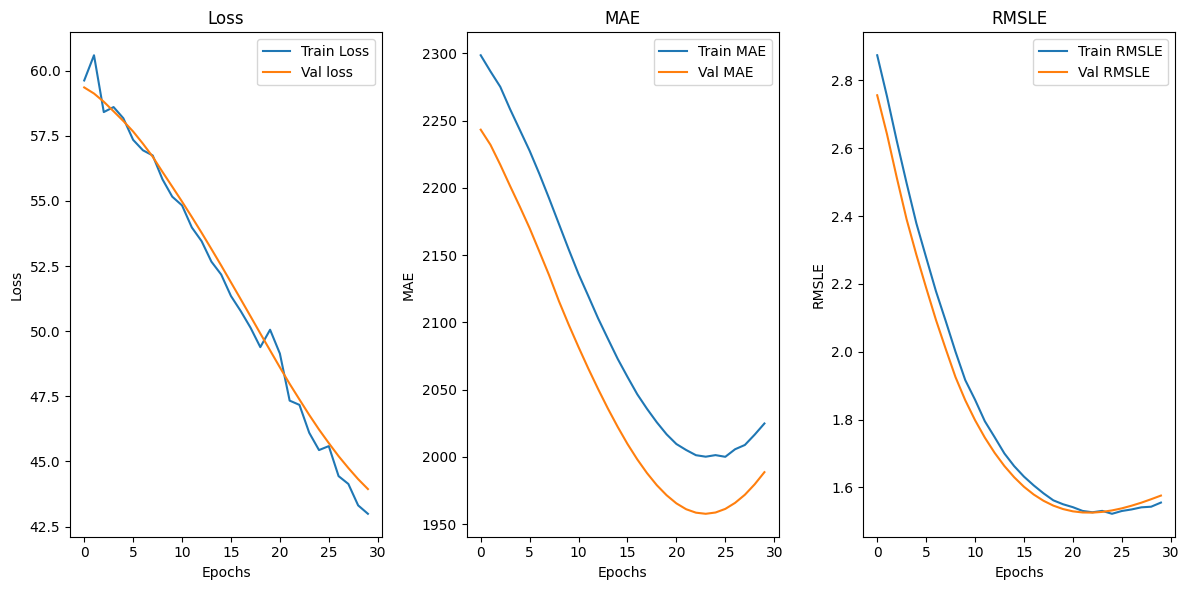

In [94]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(results["Train_MSE"], label="Train Loss")
plt.plot(results["Val_MSE"], label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 3, 2)
plt.plot(results["Train_MAE"], label="Train MAE")
plt.plot(results["Val_MAE"], label="Val MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.title("MAE")

plt.subplot(1, 3, 3)
plt.plot(results["Train_RMSLE"], label="Train RMSLE")
plt.plot(results["Val_RMSLE"], label="Val RMSLE")
plt.xlabel("Epochs")
plt.ylabel("RMSLE")
plt.legend()
plt.title("RMSLE")

plt.tight_layout()
plt.show()

In [95]:

print(f"Final Train Loss: {results['Train_MSE'][-1]}")
print(f"Final Val Loss: {results['Val_MSE'][-1]}")
model_casual(sample[0][0].to(DEVICE))

Final Train Loss: 42.988872768137504
Final Val Loss: 43.938717900776226


tensor([21.0192], device='cuda:0', grad_fn=<ReluBackward0>)

In [107]:
test_df = pd.read_csv('evaluation_data.csv')

test_df.head()
test_df = test_df.drop(columns=["dteday"])
test_df.head()

season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
0       1   0     1   0        0        4           1           1  0.26   
1       1   0     1   1        0        4           1           1  0.26   
2       1   0     1   2        0        4           1           1  0.26   
3       1   0     1   3        0        4           1           1  0.26   
4       1   0     1   4        0        4           1           1  0.26   

    atemp   hum  windspeed  
0  0.2273  0.56     0.3881  
1  0.2727  0.56     0.0000  
2  0.2727  0.56     0.0000  
3  0.2576  0.56     0.1642  
4  0.2576  0.56     0.1642

In [110]:
class RentalEvalDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.X = df.values
        
    def __getitem__(self, index: int) -> tuple[torch.Tensor]:
        return torch.tensor(self.X[index], dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.X)

In [111]:
test_dataset = RentalEvalDataset(test_df)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

sample = next(iter(test_loader))
sample[0][0].shape, sample[1][0]

(torch.Size([]), tensor(1.))

In [112]:
preds = []
with torch.inference_mode():
    for X in test_loader:
        X = X.to(DEVICE)
        casual = model_casual(X)
        registered = model_registered(X)
        output = casual + registered
        preds.extend(output.cpu().numpy())


In [114]:
output_df = pd.DataFrame(preds)

In [119]:
output_df.head()
output_df.to_csv("output.csv", index=False, header=False)